In [1]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow_text as tf_text

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
dataset_dir = '..\\data'
train_dir = f"{dataset_dir}\\tr"
batch_size = 32
seed = 42

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [5]:
FILE_NAMES = ['negativesentences.txt', 'neutralsentences.txt', 'positivesentences.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32
VALIDATION_SIZE = 5000
VOCAB_SIZE = 15000

In [17]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [18]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'Murhapolttoja, omaisuuden tuhoamista ,'
Label: 1
Sentence:  b'Tulkaa minun luokseni...min\xc3\xa4 annan teille levon...katsokaa minua: min\xc3\xa4 olen syd\xc3\xa4melt\xc3\xa4ni lempe\xc3\xa4 ja n\xc3\xb6yr\xc3\xa4..'
Label: 1
Sentence:  b'Ja mitenk\xc3\xa4 v\xc3\xa4\xc3\xa4rinkohtelusta naamakkain voisi puhua?'
Label: 1
Sentence:  b'Miten ulkokuori ja ensivaikutelma voi pett\xc3\xa4\xc3\xa4 niin pahoin?'
Label: 1
Sentence:  b'itse olen saanut niin apua kuin hyv\xc3\xa4t naurutkin monesti hulluille kirjoituksille.'
Label: 2
Sentence:  b'Asiasta kolmanteen, en ymm\xc3\xa4rr\xc3\xa4 miksi ns.'
Label: 1
Sentence:  b'"MicroSoft: using yesterday\'s technology tomorrow."'
Label: 1
Sentence:  b'Jossa me fanit voisimme keskustella toisten fanien kanssa v\xc3\xa4lill\xc3\xa4 muustakin kuin t\xc3\xa4st\xc3\xa4 oikeusjutusta.'
Label: 1
Sentence:  b'Kaveri aina luulee ett\xc3\xa4 mua vituttaa, mut mulla menee tavallaan koko ilta sii

In [24]:
tokenizer = tf_text.UnicodeScriptTokenizer()

In [9]:
def tokenize(text, unused_label):
    lower_case = tf_text.case_fold_utf8(text)
    return tokenizer.tokenize(lower_case)

tokenized_ds = all_labeled_data.map(tokenize)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [10]:
for text_batch in tokenized_ds.take(5):
    print("Tokens: ", text_batch.numpy())

Tokens:  [b'en' b'ole' b'kokeillut' b'toimiiko' b',' b'mutta' b'...']
Tokens:  [b'oikeusministeri' b'leena' b'luhtasen' b'puoliso' b'my\xc3\xb6nsi'
 b'maksaneensa' b'vaality\xc3\xb6st\xc3\xa4' b'pime\xc3\xa4sti' b','
 b'iltalehti' b'uutisoi' b'.']
Tokens:  [b'ihmisille' b',' b'lukijoille' b'vahingoksi' b'ja' b'onnettomuuksiksi'
 b'.']
Tokens:  [b'hyvin' b'varusteltu' b'saunallinen' b'm\xc3\xb6kki' b'6' b'hengelle'
 b'1,8' b'km' b'rinteisiin' b'ladulle' b'pihasta']
Tokens:  [b'yhti\xc3\xb6kokouksen' b'p\xc3\xa4\xc3\xa4tt\xc3\xa4m\xc3\xa4'
 b'p\xc3\xa4iv\xc3\xa4' b',' b'jolloin' b'osinko' b'maksetaan' b'.']


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
tokenized_ds = configure_dataset(tokenized_ds)

vocab_dict = collections.defaultdict(lambda: 0)
for toks in tokenized_ds.as_numpy_iterator():
    for tok in toks:
        vocab_dict[tok] += 1

vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
vocab = [token for token, count in vocab]
vocab = vocab[:VOCAB_SIZE]
vocab_size = len(vocab)
print("Vocab size: ", vocab_size)
print("First five vocab entries:", vocab[:5])

Vocab size:  15000
First five vocab entries: [b'.', b',', b'ja', b'on', b'ei']


In [13]:
keys = vocab
values = range(2, len(vocab) + 2)  # reserve 0 for padding, 1 for OOV

init = tf.lookup.KeyValueTensorInitializer(
    keys, values, key_dtype=tf.string, value_dtype=tf.int64)

num_oov_buckets = 1
vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)

In [14]:
def preprocess_text(text, label):
    standardized = tf_text.case_fold_utf8(text)
    tokenized = tokenizer.tokenize(standardized)
    vectorized = vocab_table.lookup(tokenized)
    return vectorized, label

In [15]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text, example_label = preprocess_text(example_text, example_label)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'En ole kokeillut toimiiko, mutta...'
Vectorized sentence:  [  19   15 1660 4436    3   14   18]


In [16]:
all_encoded_data = all_labeled_data.map(preprocess_text)

In [17]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE)

In [18]:
train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [19]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (32, 46)
Label batch shape:  (32,)
First text example:  tf.Tensor(
[  19   15 1660 4436    3   14   18    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(46,), dtype=int64)
First label example:  tf.Tensor(1, shape=(), dtype=int64)


In [20]:
vocab_size += 2

In [21]:
train_data = configure_dataset(train_data)
validation_data = configure_dataset(validation_data)

In [30]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=True),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels)
  ])
    return model

In [31]:
model = create_model(vocab_size=vocab_size, num_labels=3)
model.summary()
callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(train_data, validation_data=validation_data, callbacks=[callback], epochs=15)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          960128    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [24]:
test_loss, test_acc = model.evaluate(validation_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 3s 14ms/step - loss: 0.9491 - accuracy: 0.6390
Test Loss: 0.9491303563117981
Test Accuracy: 0.6389999985694885


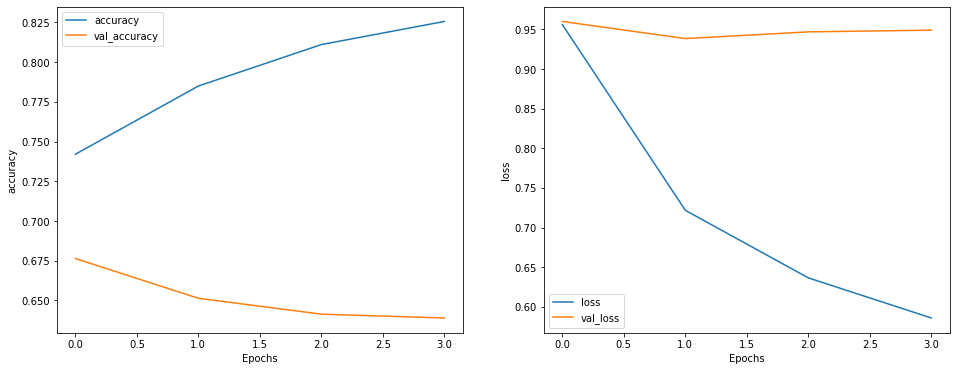

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [26]:
MAX_SEQUENCE_LENGTH = 250
preprocess_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=tf_text.case_fold_utf8,
    split=tokenizer.tokenize,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)
preprocess_layer.set_vocabulary(vocab)

In [27]:
export_model = tf.keras.Sequential(
    [preprocess_layer, model,
     layers.Activation('softmax')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [28]:
# Create a test dataset of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = configure_dataset(test_ds)
loss, accuracy = export_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

157/157 [==============================] - 21s 34ms/step - loss: 0.9660 - accuracy: 0.6312
Loss:  0.9659619331359863
Accuracy: 63.12%


In [29]:
inputs = [
    "Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.",  # Label: 1
    "Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. ",  # Label: 2
    "Sä oot mulle niin tärkeä ja rakas!",  # Label: 0
]
predicted_scores = export_model.predict(inputs)
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

Question:  Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.
Predicted label:  1
Question:  Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. 
Predicted label:  1
Question:  Sä oot mulle niin tärkeä ja rakas!
Predicted label:  2
